In [10]:
from utility import *

### Load Data

In [11]:
# CT dicom metadata
meta = pd.read_csv('meta.csv')
meta = meta.set_index('ID', drop = True)
meta.drop(['Unnamed: 0'], axis = 1, inplace = True)

#Radiomic feature, not normalized
radiomics = pd.read_csv('radiomicsCompleteNew.csv')
radiomics.drop(radiomics.columns[0:22],axis =1,inplace =True)
radiomics.dropna(inplace= True)
radiomics.set_index(['ID'],inplace = True)

# Clinical features
clinic = pd.read_excel('clinics.xlsx')
clinic = survival_info_adding(clinic)
clinic = clinic.set_index('MRN', drop = True)
clinic['1st G3-4 Late Tox'].replace('yes', 'Yes', inplace  = True)


C:\Users\iran\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:483: UserWarning: Warning: some values of start_times are after end_times
  warnings.warn("Warning: some values of start_times are after end_times")


In [13]:
# Preprocessing of Radiomics feature
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
scaler.fit(radiomics.values)
Newfeat = scaler.transform(radiomics)
radiomics = pd.DataFrame(Newfeat, index = radiomics.index, columns = radiomics.columns)
All_Features = radiomics.columns.tolist()

### HPV status

In [14]:
radioHPV = radiomics[radiomics.index.isin(clinic[clinic['HPV'].notnull()].index)]
radioHPV ['HPV']= clinic[clinic['HPV'].notnull()].HPV
radioHPV['HPV'].replace(['Yes, positive'], 1, inplace = True)
radioHPV['HPV'].replace(['Yes, Negative'], 0, inplace = True)

C:\Users\iran\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\iran\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [335]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=10000)
embedded = tsne.fit_transform(radioHPV[f.loc[f['pval']>0.05, 'feat']])
xVal = embedded[:,0]
yVal = embedded[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1250 samples in 0.151s...
[t-SNE] Computed neighbors for 1250 samples in 2.758s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1250
[t-SNE] Computed conditional probabilities for sample 1250 / 1250
[t-SNE] Mean sigma: 0.565913
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.761986
[t-SNE] KL divergence after 6600 iterations: 1.032295


(-54.17924556732179,
 64.25279674530032,
 -58.637264251708984,
 63.824344635009766)

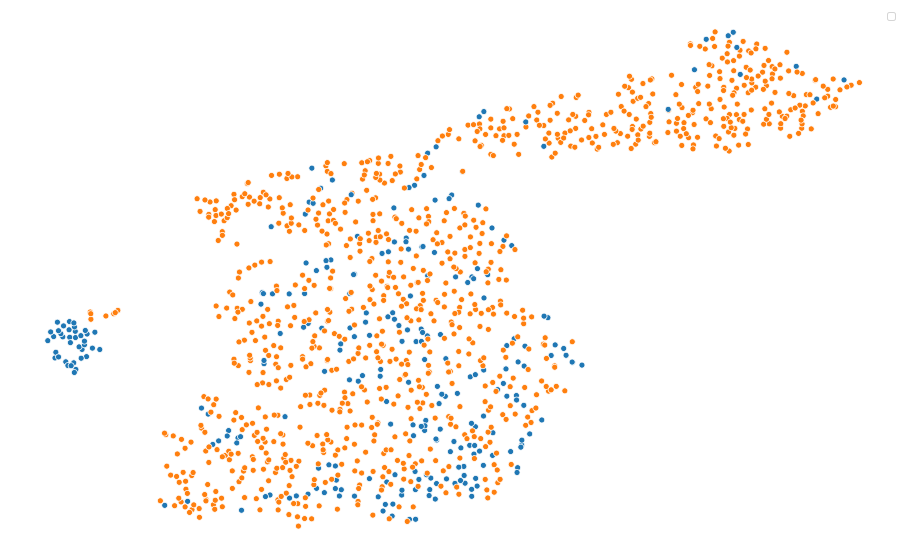

In [336]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=xVal, y=yVal,hue = radioHPV['manufacturer'])
ax = plt.gca()
plt.legend('')
plt.axis('off')

In [26]:
Democlinic = clinic.loc[radioTox.index,['ECOG PS','Smoking Hx','Drinking hx','T', 'N', 'M ', 'Stage','Path', 'HPV',
                                        'Local','Regional','Distant','Chemo? ','2nd Ca']]
cleanup_nums = {'ECOG PS':     {'ECOG 0': 0, 'ECOG-Pt 0': 0,'ECOG 1': 1, 'ECOG 2': 2, 'ECOG 3': 3, 'ECOG 4': 4, 'Unknown': np.nan},
                'T': {'T0': 0,'rT0': 0,'T1a':1,'T1': 1, 'T1b': 1,'T2': 2, 'T3': 3,'T3 (2)':3, 'T4': 4, 'T4a': 4,'T4b': 4,'Tis':5},
                'N': {'N0': 0,'N1': 1, 'N2': 2,'N2a': 2,'N2b': 2,'N2c': 2, 'N3': 3,'N3a': 3,'N3b': 3},
                'M ': {'M0': 0},
                'Stage': {'I': 1,'II':2,'IIA':2,'III':3,'IIIC':3,'IV':4,'IVA':4,'IVB':4},
                'Path': {'Squamous Cell Carcinoma': 0,'Squamous Cell Carcinoma In-Situ':0,'NPC, Type 2 (WHO IIA)':1,
                         'NPC: Type 3 (WHO IIB)':1,'NPC, Type 2 (WHO IIA':1,'NPC, Type 1 (WHO I)':1,
                         'carcinoma':2,'Adenoid Cystic':3,'Adenosquamous Cell': 4,'Neuroendocrine ca (small cell)':5,'Adenocarcinoma':6},
                'HPV': {'Yes, positive': 0,'Yes, Negative': 1,},
                'Local': {'Yes': 0,'Possible': 0,'Persistent': 1,},
                'Regional': {'Yes': 0,'Persistent': 1,},
                'Distant': {'Yes, positive': 0,'Yes, Negative': 1,},
                'Chemo? ': {'none': 0,'Yes': 1,},
                '2nd Ca': {'Y': 0,'S': 1,},
                
                 }
Democlinic.replace(cleanup_nums, inplace=True)
Democlinic[['Smoking Hx','Drinking hx']] = Democlinic[['Smoking Hx','Drinking hx']].astype('category')
Democlinic['Smoking Hx'] = Democlinic['Smoking Hx'].cat.codes
Democlinic['Drinking hx'] = Democlinic['Drinking hx'].cat.codes

Democlinic = pd.get_dummies(Democlinic, columns=['HPV','Local','Regional','Distant','2nd Ca'])
Democlinic.fillna(0, inplace = True)
Democlinic[Democlinic.columns] = Democlinic[Democlinic.columns].astype('category')

In [28]:
Democlinic_hpv = clinic.loc[radioHPV.index,['ECOG PS','Smoking Hx','Drinking hx','T', 'N', 'M ', 'Stage','Path','1st G3-4 Late Tox',
                                        'Local','Regional','Distant','Chemo? ','2nd Ca']]
cleanup_nums = {'ECOG PS':     {'ECOG 0': 0, 'ECOG-Pt 0': 0,'ECOG 1': 1, 'ECOG 2': 2, 'ECOG 3': 3, 'ECOG 4': 4, 'Unknown': np.nan},
                'T': {'T0': 0,'rT0': 0,'T1a':1,'T1': 1, 'T1b': 1,'T2': 2, 'T3': 3,'T3 (2)':3, 'T4': 4, 'T4a': 4,'T4b': 4,'Tis':5},
                'N': {'N0': 0,'N1': 1, 'N2': 2,'N2a': 2,'N2b': 2,'N2c': 2, 'N3': 3,'N3a': 3,'N3b': 3},
                'M ': {'M0': 0},
                'Stage': {'I': 1,'II':2,'IIA':2,'III':3,'IIIC':3,'IV':4,'IVA':4,'IVB':4,'IVC':4},
                'Path': {'Squamous Cell Carcinoma': 0,'Squamous Cell Carcinoma In-Situ':0,'NPC, Type 2 (WHO IIA)':1,
                         'NPC: Type 3 (WHO IIB)':1,'NPC, Type 2 (WHO IIA':1,'NPC, Type 1 (WHO I)':1,
                         'carcinoma':2,'Adenoid Cystic':3,'Adenosquamous Cell': 4,'Neuroendocrine ca (small cell)':5,'Adenocarcinoma':6},
                'HPV': {'Yes, positive': 0,'Yes, Negative': 1,},
                'Local': {'Yes': 0,'Possible': 0,'Persistent': 1,},
                'Regional': {'Yes': 0,'Persistent': 1,},
                'Distant': {'Yes, positive': 0,'Yes, Negative': 1,},
                'Chemo? ': {'none': 0,'Yes': 1,},
                '2nd Ca': {'Y': 0,'S': 1,},
                '1st G3-4 Late Tox': {'Yes': 0,'No': 1,},
   
                 }
Democlinic_hpv.replace(cleanup_nums, inplace=True)
Democlinic_hpv[['Smoking Hx','Drinking hx']] = Democlinic_hpv[['Smoking Hx','Drinking hx']].astype('category')
Democlinic_hpv['Smoking Hx'] = Democlinic_hpv['Smoking Hx'].cat.codes
Democlinic_hpv['Drinking hx'] = Democlinic_hpv['Drinking hx'].cat.codes

Democlinic_hpv = pd.get_dummies(Democlinic_hpv, columns=['Local','Regional','Distant','2nd Ca','1st G3-4 Late Tox'])
Democlinic_hpv.fillna(0, inplace = True)
Democlinic_hpv[Democlinic_hpv.columns] = Democlinic_hpv[Democlinic_hpv.columns].astype('category')

In [29]:
Democlinic_hpv = Democlinic_hpv.loc[radioHPV.index]
Democlinic_hpv.drop(['Distant_Possible','Regional_Possible','Local_0.0', 'Local_1.0', 'Regional_0',
                     'Regional_1','Distant_Yes','1st G3-4 Late Tox_1.0','1st G3-4 Late Tox_0.0'],axis = 1,inplace = True)
Democlinic_hpv['HPV'] = radioHPV['HPV']
allfeat = pd.concat([radioHPV[radioHPV.columns[:-1]], Democlinic_hpv],axis = 1)

In [30]:
Features = radiomics.columns
firstorder_wavelet =     [feature for feature in Features if feature.split('_')[1] == 'firstorder' and feature.split('_')[0].startswith('wavelet')]
glcm_wavelet =     [feature for feature in Features if feature.split('_')[1] == 'glcm' and feature.split('_')[0].startswith('wavelet')]
wavelet =     [feature for feature in Features if feature.split('_')[0].startswith('wavelet')]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement as rsm

Toshiba, GE = manufacturer_splitting(radioHPV,meta)

# ge_ge = pd.DataFrame(columns=['fpr','tpr','auc'])
# ge_tosh = pd.DataFrame(columns=['fpr','tpr','auc'])
# ge_mix = pd.DataFrame(columns=['fpr','tpr','auc'])
# tosh_tosh = pd.DataFrame(columns=['fpr','tpr','auc'])
# tosh_ge = pd.DataFrame(columns=['fpr','tpr','auc'])
# tosh_mix = pd.DataFrame(columns=['fpr','tpr','auc'])
# mix_mix = pd.DataFrame(columns=['fpr','tpr','auc'])
# mix_tosh = pd.DataFrame(columns=['fpr','tpr','auc'])
# mix_ge = pd.DataFrame(columns=['fpr','tpr','auc'])

# cl1 = pd.DataFrame(columns=['fpr','tpr','auc'])
# cl2 = pd.DataFrame(columns=['fpr','tpr','auc'])
# cl3 = pd.DataFrame(columns=['fpr','tpr','auc'])

# robust_filter_hpv = []
# robust_feature_hpv = []

feat_g_mrmr_1 = []
feat_t_mrmr_1 = []
feat_mix_mrmr_1 = []

fil_g_mrmr_1 = []
fil_t_mrmr_1 = []
fil_mix_mrmr_1 = []


for i in range(100):  
    
    print('Study number "',i)
    print('-------------------------------')
    print('Data splitting ...')
    
#     train, test = train_test_split (Democlinic_hpv.iloc[rsm(len(Democlinic_hpv),len(Democlinic_hpv)*0.8)], test_size=0.25)
#     model = train_model(train[train.columns[:-1]],train['HPV']) 
#     fpr,tpr,auc = test_model(model, test[test.columns[:-1]],test['HPV'])
#     cl1 = cl1.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

#     train, test =train_test_split (radioHPV.iloc[rsm(len(radioHPV),len(radioHPV)*0.8)], test_size=0.25)
#     feat = mrmr_feat (radioHPV.loc[train.index],100)
#     model = train_model(train[feat],train['HPV']) 
#     fpr,tpr,auc = test_model(model, test[feat],test['HPV'])
#     cl2 = cl2.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    
#     train, test =train_test_split (allfeat.iloc[rsm(len(allfeat),len(allfeat)*0.8)], test_size=0.25)
#     model = train_model(train[np.append(feat,Democlinic_hpv.columns[:-1])],train['HPV']) 
#     fpr,tpr,auc = test_model(model, test[np.append(feat,Democlinic_hpv.columns[:-1])],test['HPV'])
#     cl3 = cl3.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
#     print('Job ', i, ' is done')
    
# cl1.to_csv('CL.csv')
# cl2.to_csv('CL.csv')
# cl3.to_csv('CL.csv')



    
    GEneg = GE[GE['HPV'] == 0]
    GEpos = GE[GE['HPV'] == 1]
    train_gneg, test_gneg = train_test_split (GEneg.iloc[rsm(len(GEneg),len(GEneg)*0.8)], test_size=0.25)
    train_gpos, test_gpos = train_test_split (GEpos.iloc[rsm(len(GEpos),len(GEneg)*0.8)], test_size=0.25)
    train_g = pd.concat([train_gneg,train_gpos])
    test_g = pd.concat([test_gneg,test_gpos])
    
    Toshibaneg = Toshiba[Toshiba['HPV'] == 0]
    Toshibapos = Toshiba[Toshiba['HPV'] == 1]
    train_tneg, test_tneg = train_test_split (Toshibaneg.iloc[rsm(len(Toshibaneg),len(GEneg)*0.8)], test_size=0.25)
    train_tpos, test_tpos = train_test_split (Toshibapos.iloc[rsm(len(Toshibapos),len(GEneg)*0.8)], test_size=0.25)
    train_t = pd.concat([train_tneg,train_tpos])
    test_t = pd.concat([test_tneg,test_tpos])
    
    
    mixneg = radioHPV[radioHPV['HPV'] == 0]
    mixpos = radioHPV[radioHPV['HPV'] == 1]
    train_mneg, test_mneg = train_test_split (mixneg.iloc[rsm(len(mixneg),len(GEneg)*0.8)], test_size=0.25)
    train_mpos, test_mpos = train_test_split (mixpos.iloc[rsm(len(mixpos),len(GEneg)*0.8)], test_size=0.25)
    train_mix = pd.concat([train_mneg,train_mpos])
    test_mix = pd.concat([test_mneg,test_mpos])
    
    
    
    
    
#     Robust features are selected based on wilcoxon rank-sum test and p-value was corrected using Bonferoni
#     print('Wilcoxon rank-sum test ...')  
    
#     f = RankSumTest2(train_g[train_g.columns[:-1]],train_t[train_t.columns[:-1]])
#     f['pval'] = multi.multipletests(f['pval'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
#     robust_filter_hpv.append(filter_class(f.loc[f['pval']>0.05, 'feat'])[1])
#     robust_feature_hpv.append(feature_class(f.loc[f['pval']>0.05, 'feat'])[1])

        
#     f = RankSumTest1(train_g[train_g.columns[:-1]],train_t[train_t.columns[:-1]])
  

#     robust_feat=  [feat for feat,pval in zip(f[0],f[1][1]) if pval > 0.05]
#     print('Number of robust features: ',len(robust_feat))

    feat_g = mrmr_feat (train_g,100)
#     feat_g_mrmr_1.append(feature_class(feat_g)[1])
#     fil_g_mrmr_1.append(filter_class(feat_g)[1])

#     feat_g = train_g.columns[:-2]
#     feat_g = robust_feat

#     feat_g = cox_selection(train_g, 0.6)
#     print('lenght of cox_g feats: ', len(feat_g))


    feat_t = mrmr_feat (train_t,100)
#     feat_t_mrmr_1.append(feature_class(feat_t)[1])
#     fil_t_mrmr_1.append(filter_class(feat_t)[1])

#     feat_t = mrmr_feat (train_t[train_t.columns[:-1]],100)
#     feat_t = train_t.columns[:-2]
#     feat_t = cox_selection(train_t,0.6)
#     print('lenght of cox_t feats: ', len(feat_t))
#     feat_t = robust_feat

    feat_mix = mrmr_feat (train_mix[train_mix.columns[:-1]],100)
#     feat_mix_mrmr_1.append(feature_class(feat_mix)[1])
#     fil_mix_mrmr_1.append(filter_class(feat_mix)[1])
#     feat_mix = mrmr_feat (train_mix[train_mix.columns[:-2]],100)
#     feat_mix = mrmr_feat (train_mix.drop(['manufacturer'],axis=1),100)
#     feat_mix = train_mix.columns[:-3]
#     feat_mix = cox_selection(train_mix.drop(['manufacturer'],axis=1),0.6)
#     print('lenght of cox_mix feats: ' ,len(feat_mix))
#     feat_mix = robust_feat
    
    model_g   = train_model(train_g[feat_g],train_g['Tox'])
    model_t  = train_model(train_t[feat_t],train_t['Tox'])  
    model_mix = train_model(train_mix[feat_mix],train_mix['Tox']) 
    
    
    
    print('Testing ...')
    print('GE(mRMR) on GE: ')   

    fpr,tpr,auc = test_model(model_g, test_g[feat_g],test_g['Tox'])
    ge_ge = ge_ge.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    
    print('GE(mRMR) on Toshiba: ')    
    fpr,tpr,auc  = test_model(model_g, test_t[feat_g],test_t['Tox'])
    ge_tosh = ge_tosh.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    
    print('GE(mRMR) on Mix: ')    
    fpr,tpr,auc = test_model(model_g, test_mix[feat_g],test_mix['Tox'])
    ge_mix = ge_mix.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    
    print('Toshiba(mRMR) on GE: ')                                                                                                        
    fpr,tpr,auc = test_model(model_t, test_g[feat_t],test_g['Tox'])
    tosh_ge = tosh_ge.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
 
    
    print('Toshiba(mRMR) on Toshiba: ')  
    fpr,tpr,auc = test_model(model_t, test_t[feat_t],test_t['Tox'])
    tosh_tosh = tosh_tosh.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    
    print('Toshiba(mRMR) on Mixed: ')  
    fpr,tpr,auc = test_model(model_t, test_mix[feat_t],test_mix['Tox'])
    tosh_mix = tosh_mix.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    
    print('Mix(mRMR) on GE: ')
    fpr,tpr,auc = test_model(model_mix, test_g[feat_mix],test_g['Tox'])
    mix_ge = mix_ge.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
    
    print('Mix(mRMR) on Toshiba')  
    fpr,tpr,auc = test_model(model_mix, test_t[feat_mix],test_t['Tox'])
    mix_tosh = mix_tosh.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)
 
    print('Mix(mRMR) on Mix: ') 
    fpr,tpr,auc = test_model(model_mix, test_mix[feat_mix],test_mix['Tox'])
    mix_mix = mix_mix.append({'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

    print('-------------------------------')
    print('Job ', i, ' is done')

In [252]:
filter_hpv = pd.DataFrame(robust_filter_hpv, columns = filter_class(f.loc[f['pval']>0.05, 'feat'])[0])

Text(0, 0.5, 'Number of Robust features')

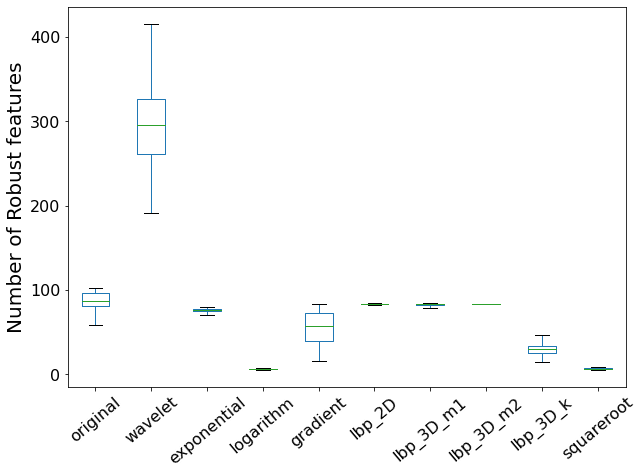

In [253]:
filter_hpv.boxplot(rot = 40,grid = False,fontsize = 16,figsize = (10,7), showfliers=False)
plt.ylabel('Number of Robust features', fontsize = 20)

In [254]:
# This is to calculate the number of featurs and then the 
# robust feature in each filter will be normalized to the number of features in each class
Features = radiomics.columns
original =    [feature for feature in Features if feature.split('_')[0].startswith('original')]
wavelet =     [feature for feature in Features if feature.split('_')[0].startswith('wavelet')]
exponential = [feature for feature in Features if feature.split('_')[0].startswith('exponential')]
logarithm = [feature for feature in Features if feature.split('_')[0].startswith('logarithm')]
gradient =    [feature for feature in Features if feature.split('_')[0].startswith('gradient')]
lbp_2D =      [feature for feature in Features if feature.split('_')[0].startswith('lbp-2D')]
lbp_3D_m1 =   [feature for feature in Features if feature.split('_')[0].startswith('lbp-3D-m1')]
lbp_3D_m2 =   [feature for feature in Features if feature.split('_')[0].startswith('lbp-3D-m2')]
lbp_3D_k =    [feature for feature in Features if feature.split('_')[0].startswith('lbp-3D-k')]
square =      [feature for feature in Features if feature.split('_')[0].startswith('square')]
squareroot =  [feature for feature in Features if feature.split('_')[0].startswith('squareroot')]

NumberofFeatureinEachFiletr = [np.shape(original)[0],np.shape(wavelet)[0],np.shape(exponential)[0],np.shape(logarithm)[0],
                               np.shape(gradient)[0],np.shape(lbp_2D)[0],np.shape(lbp_3D_m1)[0],np.shape(lbp_3D_k)[0],
                               np.shape(square)[0], np.shape(squareroot)[0]]

Text(0, 0.5, 'Proportion of robust features')

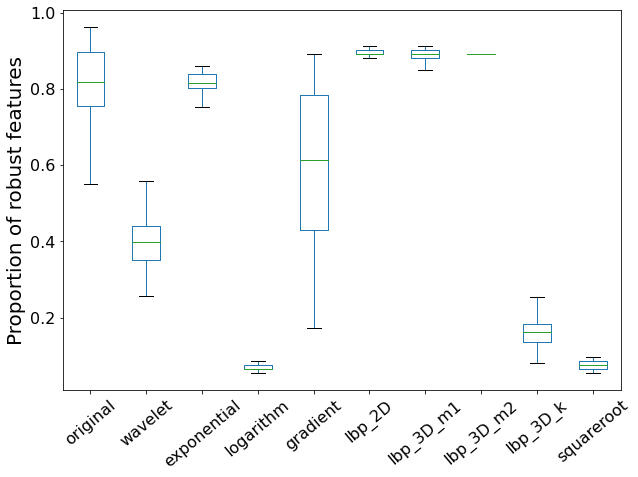

In [255]:
(filter_hpv/NumberofFeatureinEachFiletr).boxplot(rot = 40,grid = False,fontsize = 16,figsize = (10,7), showfliers=False)
plt.ylabel('Proportion of robust features', fontsize = 20)

In [256]:
feature_hpv = pd.DataFrame(robust_feature_hpv, columns = feature_class(f.loc[f['pval']>0.05, 'feat'])[0]).T

In [257]:
feature_hpv.T['shape'].replace([1,2,3,4,5,6,7,8,9,10,11],12, inplace  = True)

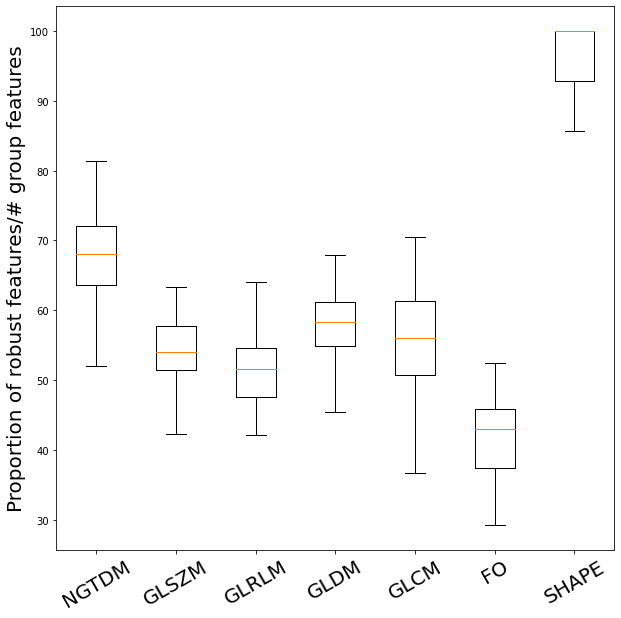

In [283]:
boxplotting_1(feature_hpv,'','Proportion of robust features/# group features')

In [134]:
# filter_hpv = pd.DataFrame(np.transpose(robust_feature_hpv))
# filter_hpv['feat'] = feature_class(f.loc[f['pval']>0.05].feat)[0]
# filter_hpv['avg'] = round(filter_hpv.mean(axis = 1))
# filter_hpv['std'] = robust_hpv.iloc[:,:-1].std(axis = 0,skipna = True)

Text(0.5, 1.0, 'FO')

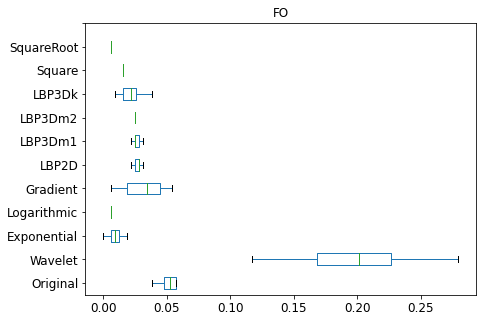

In [326]:
# NGTDM = (robustF_g.iloc[56:].sum()/75)*100
# GLSZM = (robustF_g.iloc[45:56].sum()/270)*100
# GLRLM = (robustF_g.iloc[34:45].sum()/273)*100
# GLDM =  (robustF_g.iloc[23:34].sum()/240)*100
# GLCM = (robustF_g.iloc[12:23].sum()/360)*100
# FO =  (robustF_g.iloc[1:12].sum()/315)*100
# SHAPE = (robustF_g.iloc[0:1].sum()/14)*100

(feature_hpv.iloc [1:12]/315).T.boxplot(grid = False, fontsize=12,vert=False, figsize = (7,5), showfliers=False)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11,12],['Original','Wavelet','Exponential',
'Logarithmic','Gradient','LBP2D','LBP3Dm1','LBP3Dm2','LBP3Dk','Square', 'SquareRoot'])
# plt.yticks([])
plt.title('FO')

In [27]:
# ge_ge.to_csv('GE-GE.csv')
# ge_tosh.to_csv('GE-TOSHIBA.csv')
# ge_mix.to_csv('GE-MIX.csv')
# tosh_tosh.to_csv('TOSHIBA-TOSHIBA.csv')
# tosh_ge.to_csv('TOSHIBA-GE.csv')
# tosh_mix.to_csv('TOSHIBA-MIX.csv')
# mix_mix.to_csv('MIX-MIX.csv')
# mix_ge.to_csv('MIX-GE.csv')
# mix_tosh.to_csv('MIX-TOSHIBA.csv')

In [475]:
# NGTDM = (robustF_g.iloc[56:].sum()/75)*100
# GLSZM = (robustF_g.iloc[45:56].sum()/270)*100
# GLRLM = (robustF_g.iloc[34:45].sum()/273)*100
# GLDM =  (robustF_g.iloc[23:34].sum()/240)*100
# GLCM = (robustF_g.iloc[12:23].sum()/360)*100
# FO =  (robustF_g.iloc[1:12].sum()/315)*100
# SHAPE = (robustF_g.iloc[0:1].sum()/14)*100

To_mrmr = pd.DataFrame(feat_mix_mrmr_1, columns =feature_class(feat_t)[0])
To_mrmr.iloc[:,:1].mean().sum()

2.68

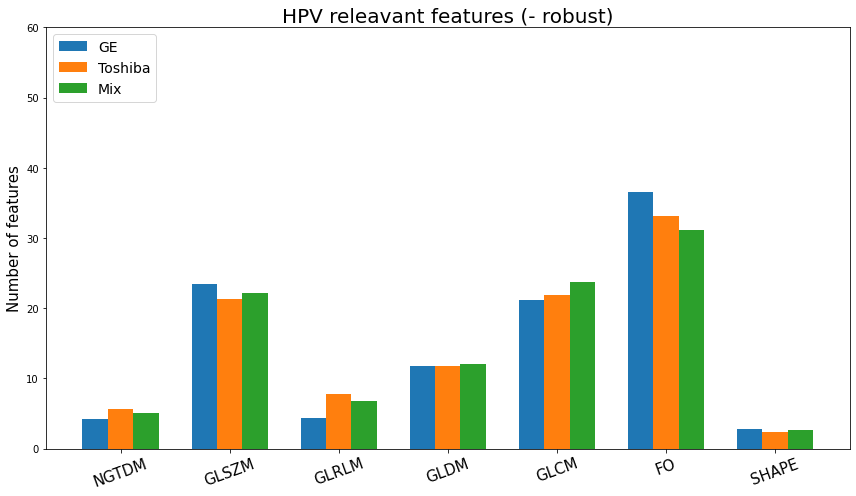

In [481]:
# g_mrmr = pd.DataFrame(feat_g_mrmr, columns =feature_class(feat_g)[0])
# t_mrmr = pd.DataFrame(feat_t_mrmr, columns =feature_class(feat_t)[0])
# mix_mrmr = pd.DataFrame(feat_mix_mrmr, columns =feature_class(feat_mix)[0])


labels = ['NGTDM','GLSZM', 'GLRLM', 'GLDM', 'GLCM','FO','SHAPE']
# labels = ['original', 'wavelet', 'exponential', 'logarithm', 'gradient',
#           'lbp_2D', 'lbp_3D_m1', 'lbp_3D_m2', 'lbp_3D_k', 'squareroot']

# proportion of features based on filter type with robustness
# ge = [10.57, 49.49,  8.59,  1.43,  8.59,  1.98,  2.23,  2.13,  7.65,1.48]
# To = [13.57, 56.24,  2.58,  0.71,  6.11,  2.19,  1.67,  1.9 ,  8.67,1.15]
# mi  = [12.1, 54.27,  5.68,  0.72,  6.49,  2.03,  1.63,  1.83,  8.55,1.13]

# proportion of features based on filter type without robustness
# ge = [6.06, 43.21,  5.07,  5.8 ,  6.02,  4.46,  4.47,  4.62,  9.05,3.7]
# To = [6.45, 50.55,  3.5 ,  6.39,  5.07,  2.  ,  2.65,  1.9 , 10.06,3.27]
# mi  = [7.57, 50.48,  3.57,  3.83,  5.32,  2.41,  2.83,  1.94, 10.41,3.2]

# proportion to total number of features based on feature class with robustness
# ge = [4.96,16.82,5.07,13.22,20.3,38,2.95]
# To = [4.68,16.74,5.97,12.8,22,35.21,3.03]
# mi = [4.09,17.93,6.14,12.85,22,33.43,3.03]

# proportion to total number of features based on feature class without robustness
ge = [4.14,23.43,4.38,11.7,21.1,36.56,2.82]
To = [5.63,21.28,7.78,11.69,21.85,33.14,2.33]
mi = [5.06,22.11,6.84,12.0,23.79,31.1,2.68]

x = np.array([3,6,9,12,15,18,21])  # the label locations
width = 2.1  # the width of the bars

fig, ax = plt.subplots(figsize = (12,7))
rects1 = ax.bar(x - width/3, ge, width/3, label='GE')
rects2 = ax.bar(x , To, width/3, label='Toshiba')
rects3 = ax.bar(x + width/3, mi, width/3, label='Mix')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of features', fontsize = 15)
ax.set_title('HPV releavant features (- robust)',fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15, rotation = 20)
ax.legend(fontsize = 14, loc = 'upper left')
plt.ylim(0, 60)


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     fontsize = 15,
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

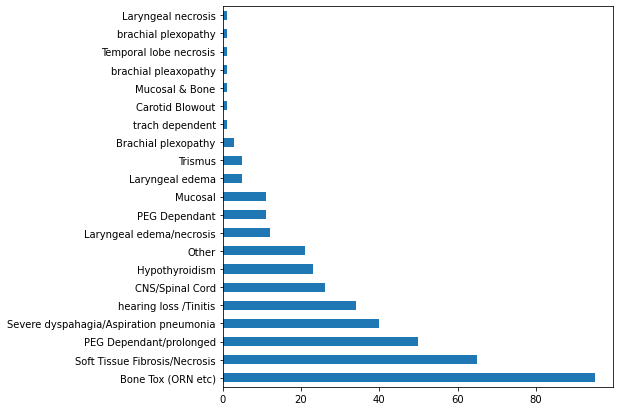

In [348]:
clinic.loc[radioTox.index, 'Type of 1st G3-4 Late Tox'].value_counts().plot.barh(figsize = (7,7))